In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import scipy
import datetime

# third party packages
from PIL import Image

# from my code
from src import repo_tools, data_tools, image_tools, signals_processing_tools, carbon_calculation_tools

### find images

In [2]:
# old_img_names = os.listdir(os.path.join("data", "images"))
cwd = os.getcwd()
# old_img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in old_img_names}
# repo_tools.shorten_image_file_names(old_img_paths, cwd)

img_names = [img_name for img_name in os.listdir(os.path.join("data", "images")) if "png" in img_name]
img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in img_names}
img_paths.keys()

dict_keys(['123946.png', 'Screenshot 2022-10-26 123946.png', 'Screenshot 2022-10-26 124245.png', '124245.png', '124105.png', 'Screenshot 2022-10-26 124105.png', '124205.png', 'Screenshot 2022-10-26 124205.png'])

### import image

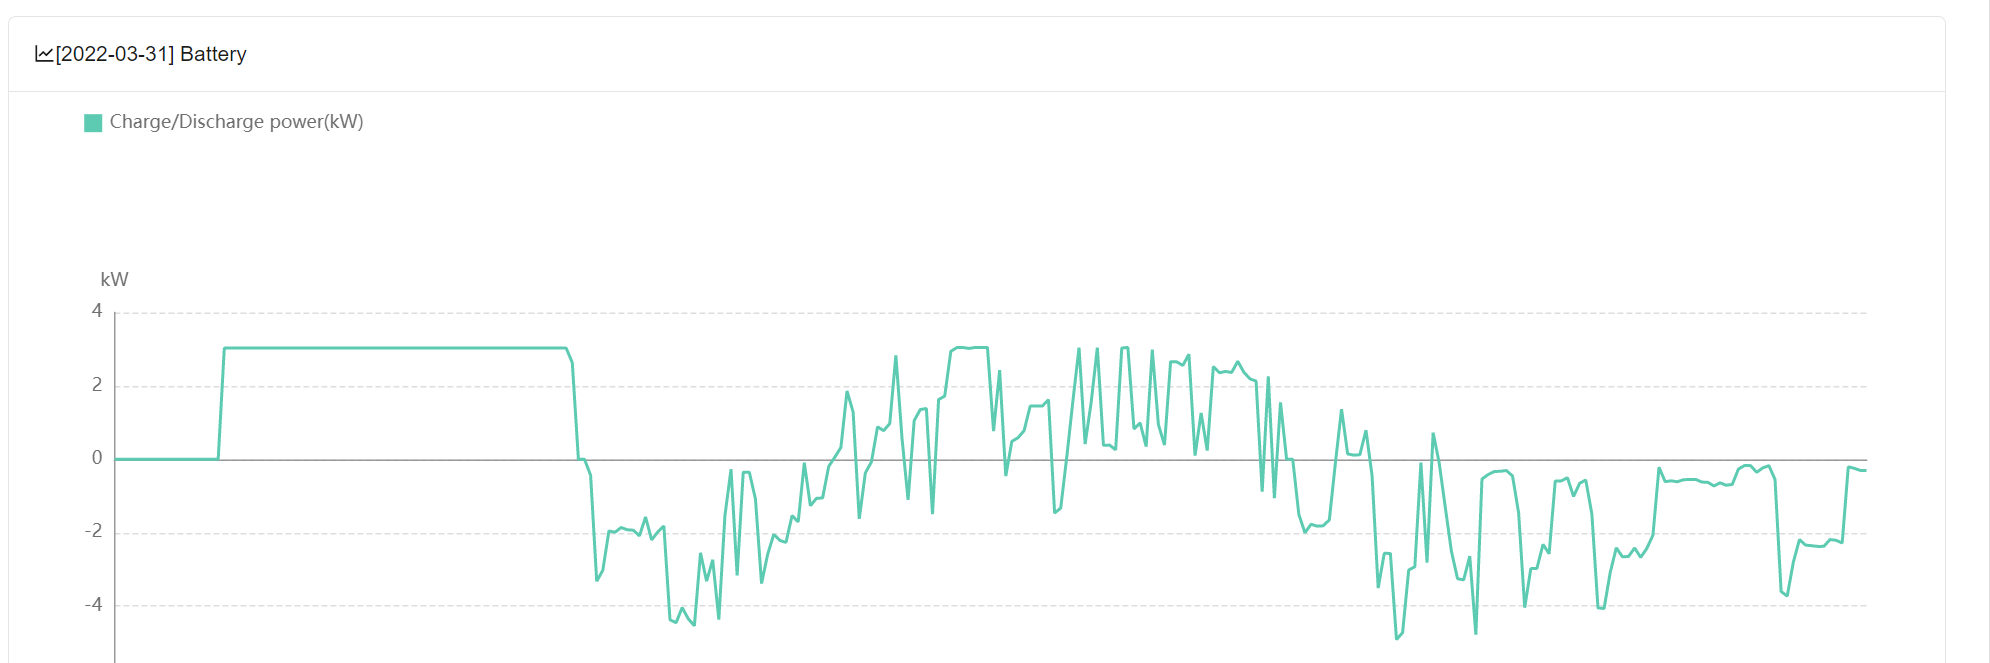

In [3]:
# exract the image
img = Image.open(img_paths[img_names[0]]).convert("RGB")

# show the image
img

This plot shows the charge and discharge data for Ian's home battery over a given day. The y axis represents the power consupmtion of the battery from the grid. Positive values, i.e. above the baseline, correspond to the battery being charged from the grid. Inversely, negative values represent when the battery is discharging, and helping to power the home. Currently this is being done in the simplest way possible, in that the battery charges up at night when the electricity prices are lower, and then it discharges in the day- to supply the houses electricity- when the cost of electricity is higher, therefore tapping into these 'delta' values in the price range of electricity to save money. This image shows the ideal scenario, in that the battery has not ran out of charge throughout the day and therefore the demand from the grid during the day was 0. Great.

However, this won't always happen, especially in winter when the household electricity demands are higher. The battery will run out at some point in the day. With this constraint in mind, we move to the real point of this project.

This process could be optimised to reduce the carbon footprint of the household. 

## Carbon intensity of the grid

The national grid has a continously changing proportion of its power coming supply coming from renewable sources. It would be ideal to charge up Ian's battery when the renewable proportion is highest, therefore the carbon intensity per kW is lowest. 

Furthermore, if the battery is programmed to discharge when the carbon intensity of the grid is at its highest, say in the early evening when everyone is at home and the grid has turned up the gas consumption to match demand, the battery discharge will serve the household electricity demands reducing the use of eletricity from the grid- within constraints as the battery has a maximum discharge rate.

If only we could predict the carbon intensity of the grid for the upcoming 24 hour period, in order to charge at the lowest, and discharge at the highest, carbon intensity values. 

Thanks to these guys, we do:

https://carbonintensity.org.uk

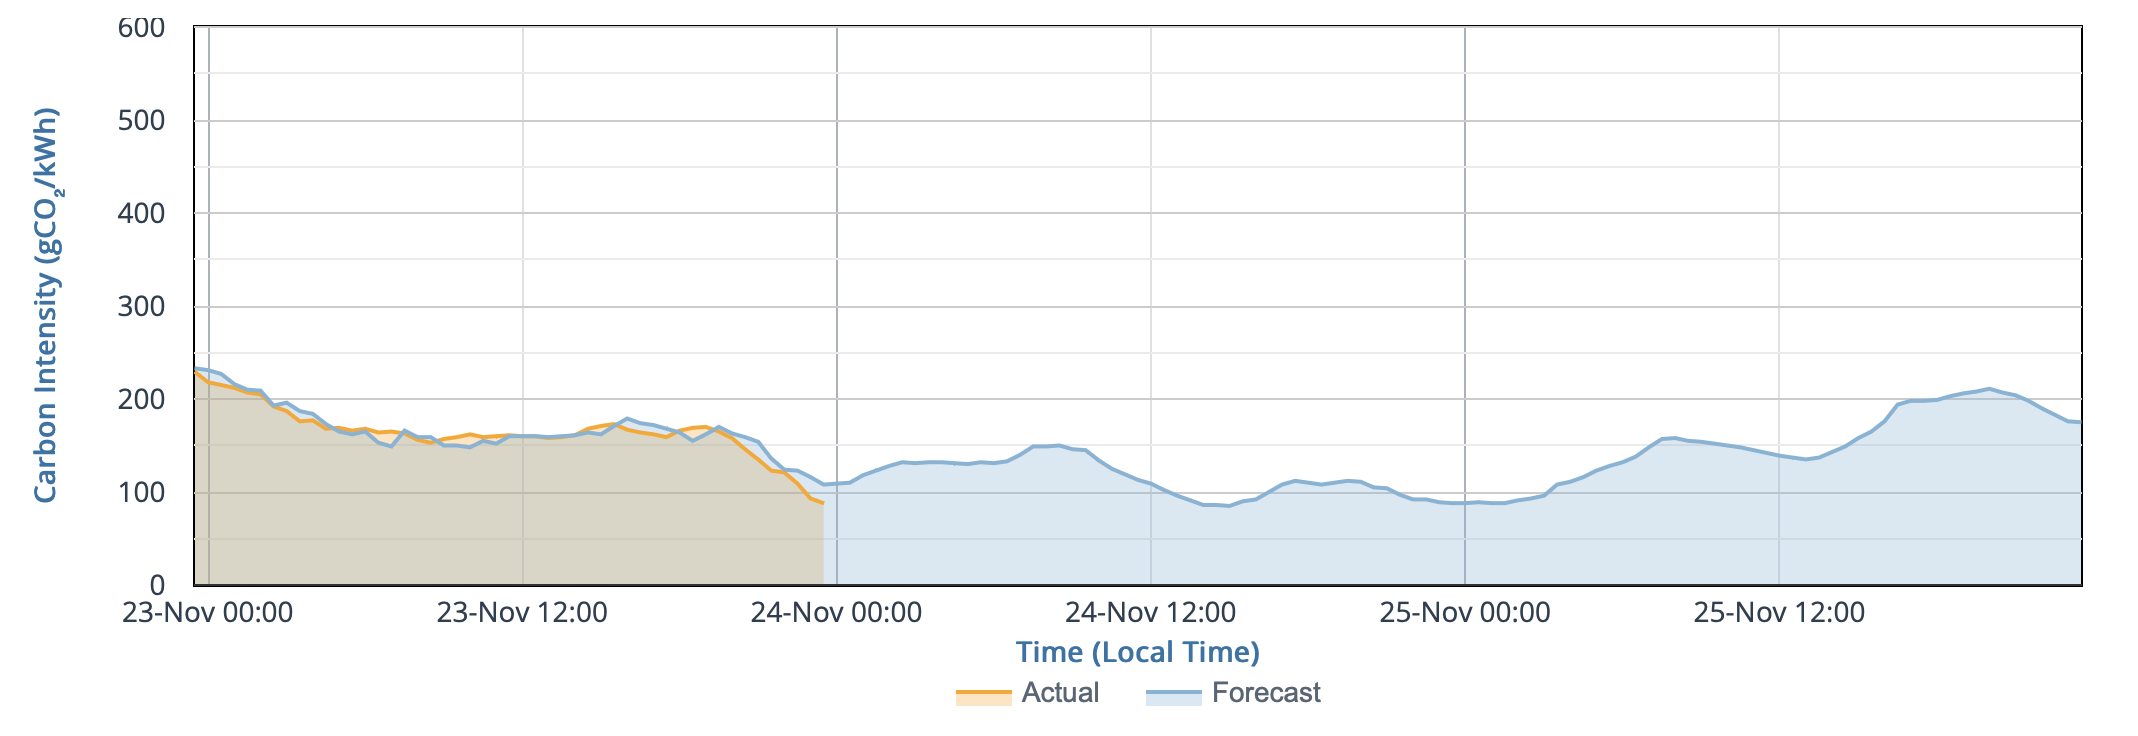

## Lets do some calculations

So, if we can predict the upcoming national grid carbon intensity within reason, lets see how much carbon could be saved if we adopted an 'intelligent' charge and discharge procedure. 

The starting point of this is to calculate the relative value of carbon intensity from the 'dumb' approach. And the data provided was these images provided. 

So, lets scrape the data from these images. Woopeeee

## x calibration 

In [4]:
arr_data_pix_coords = image_tools.find_data_coordinates(img)

baseline_x = min(arr_data_pix_coords[:,0])
last_data_point_x = max(arr_data_pix_coords[:,0])
seconds_in_day = 60*60*24
seconds_per_pixel = seconds_in_day / abs(last_data_point_x - baseline_x)
baseline_x, seconds_per_pixel

(115, 49.371428571428574)

## y calibration

In [5]:
y_coord_dict, baseline_y, kw_per_pixel = signals_processing_tools.compute_y_calibrations(img)

An outline of this method and how it was developed can be found in the image_processing_experiments.ipynb notebook. Code is found in various .py files. 

It uses Image processing methods such as 2d convolutions with a horizontal filter to detect horizontal lines through peak detection of the response to this convolutional filter.

#### checking y calibration

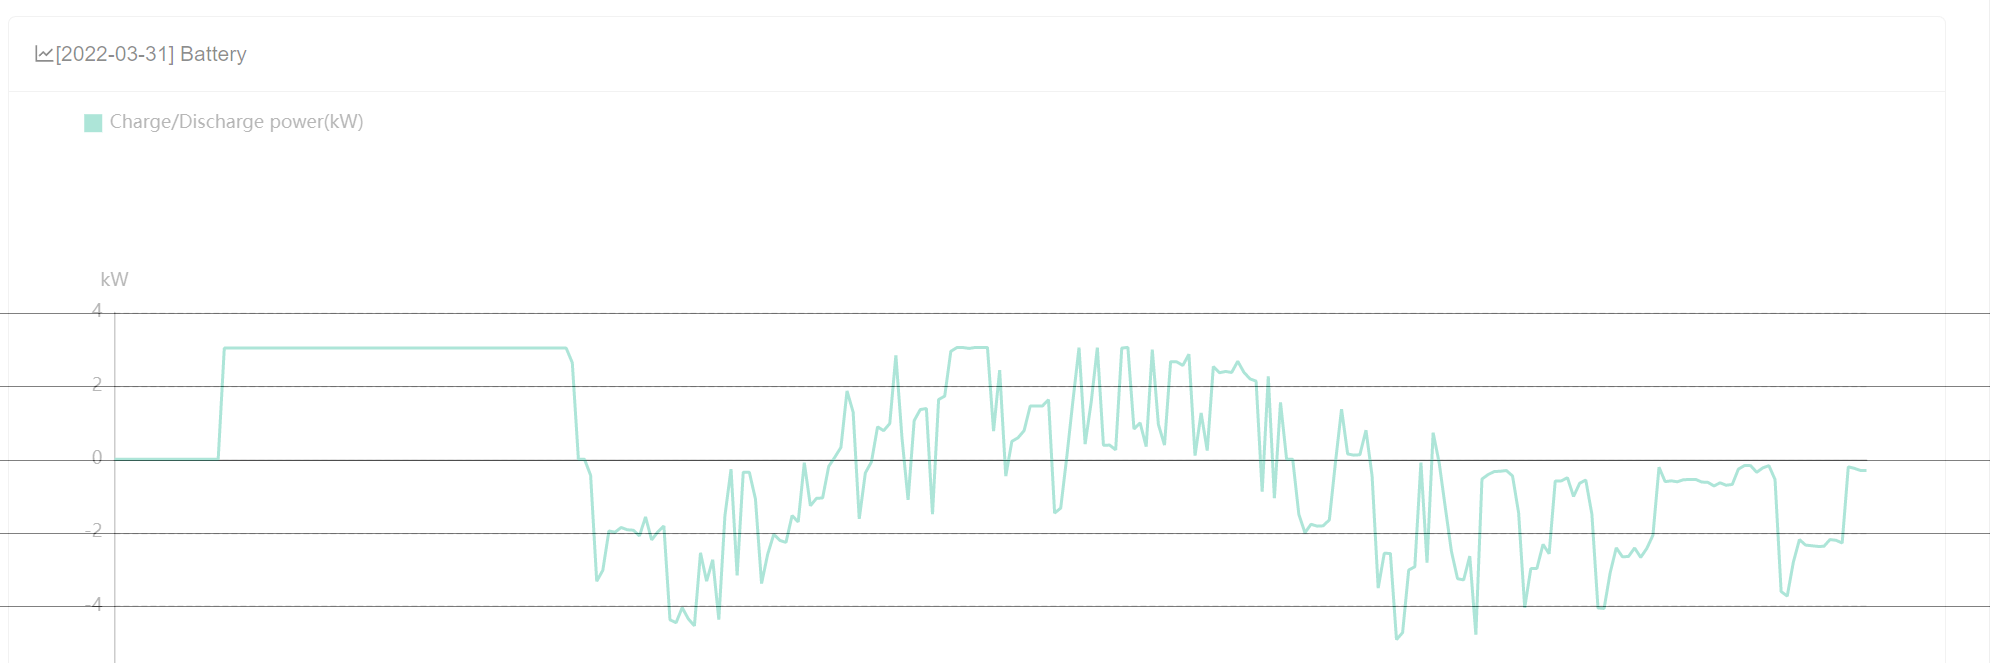

In [6]:
# check these values 
img_arr = np.asarray(img)
img_height = img_arr.shape[0]
img_width = img_arr.shape[1]
min(arr_data_pix_coords[:,1])

# generate white page with black lines image for pasting on top of original image, for reference
black_line_pix_values = np.zeros((1,img_width,3), dtype="uint8")
white_image = np.ones(np.shape(img_arr),dtype="uint8")*255
for y_val in y_coord_dict:
    white_image[y_coord_dict[y_val]] =  black_line_pix_values
    
lines = Image.fromarray(white_image)
img_with_lines = img.copy()
lines.putalpha(127) # make partially transparent

# paste the two images together
img_with_lines.paste(lines, (0,0), lines)
img_with_lines

This plot shows the original image with an overlay of the predicted y grid lines using the image processing tools defined in this repository. They should line up. 

# putting them together

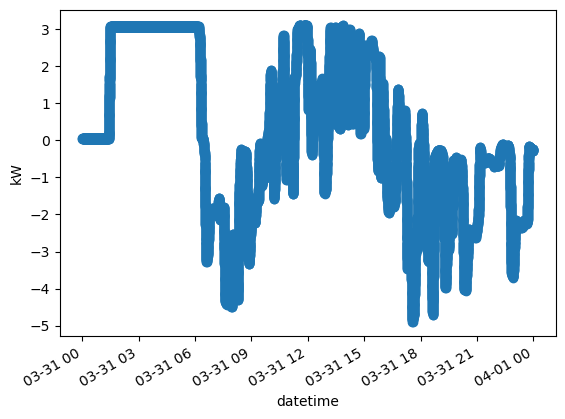

In [21]:
# extract array of data values with dimensions in Y of kW, and x of seconds in the day
day_str = "2022-03-31"
data_x = (arr_data_pix_coords[:,0] - baseline_x) * seconds_per_pixel # x dimensions are seconds
data_x = data_tools.convert_x_data_to_datetime(day_str, data_x) # converted to datetime
data_y = (arr_data_pix_coords[:,1] - baseline_y) * kw_per_pixel # y direction are kW

plt.scatter(data_x, data_y)
plt.xlabel("datetime")
plt.ylabel("kW")
plt.gcf().autofmt_xdate()
plt.savefig("images/battery_data_extracted_from_images.png")

This looks good.

In [8]:
# quick sanity check this number should be around 0
np.sum(data_y)/seconds_in_day

-0.06383169005182654

Close enough

# What to do with this data

Now we've scraped the data from these images, lets calculate the a carbon intensity metric.

For this, we need historic data on carbon intensity in the grid. 

.csv data is downloaded from https://www.carbonintensity.org.uk/ one month at a time and saved in the folder data/grid_data. 

### collect all ci data that's been imported

In [9]:
all_ci_data = data_tools.generate_csv_all_data(relative_path=os.path.join("data","grid_data"))
all_ci_data["datetime"] = pd.to_datetime(all_ci_data["Datetime (UTC)"]).dt.tz_localize(None)
all_ci_data.sort_values(by='datetime', inplace=True)
# all_ci_data.to_csv(os.path.join("data", "all_ci_data.csv"))
all_ci_data.head()

,Datetime (UTC),Actual Carbon Intensity (gCO2/kWh),Forecast Carbon Intensity (gCO2/kWh),Index,datetime
7205,2022-01-01T00:00Z,71.0,83,low,2022-01-01 00:00:00
7206,2022-01-01T00:30Z,74.0,74,low,2022-01-01 00:30:00
7207,2022-01-01T01:00Z,75.0,70,low,2022-01-01 01:00:00
7208,2022-01-01T01:30Z,73.0,70,low,2022-01-01 01:30:00
7209,2022-01-01T02:00Z,68.0,61,low,2022-01-01 02:00:00


### find all CI data for one day


In [10]:
ci_data = data_tools.extract_data_for_day(all_ci_data, day_str)

### plots CI data for one day against battery consumption

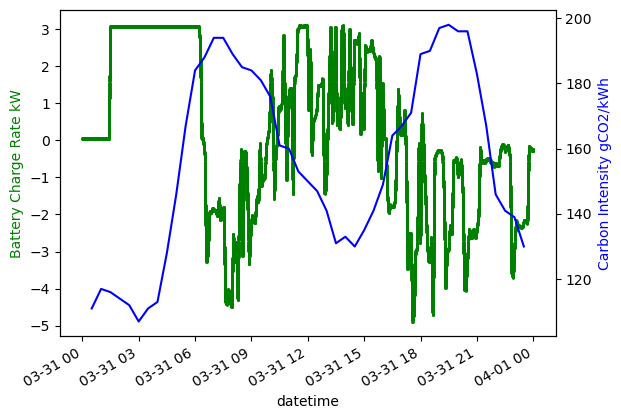

In [11]:
fig,ax1 = plt.subplots()

ax1.scatter(data_x, data_y, color='g', s=1)
ax1.set_xlabel("datetime")
ax1.set_ylabel("Battery Charge Rate kW", color='g')

ax2=ax1.twinx()
ax2.plot(ci_data['datetime'], ci_data['Actual Carbon Intensity (gCO2/kWh)'], color='b')
ax2.set_ylabel("Carbon Intensity gCO2/kWh", color='b')
plt.gcf().autofmt_xdate()

So far, the simple method of charging up overnight and discharging throughout the day to meet demand, which is chosen to save monetary costs, does seem to lead to a well designed system with the battery generally charging up when CI is low, and discharging when it is high. 

The charging up throughout midday is due to excess power generated through the solar cells on Ian's roof being used to charge up the battery.

# Now to get a measurement of CI from the day

In [12]:
# calculate interpolated battery charge values for the time intervals of CI data
time_intervals = ci_data["datetime"]
# data_x.astype("object")

new_x_coords = np.arange(len(time_intervals)) * len(data_y) / len(time_intervals)
interpolated_battery_data = np.interp(new_x_coords, np.arange(len(data_y)), data_y.astype("float"))
interpolated_battery_data

array([ 3.11262799,  3.08532423,  3.05802048,  2.78498294,  2.53924915,
        2.34812287,  2.15699659,  1.96587031,  1.77474403,  1.58361775,
        1.44709898,  1.3105802 ,  1.17406143,  1.06484642,  0.92832765,
        0.81911263,  0.68259386,  0.57337884,  0.43686007,  0.3003413 ,
        0.13651877,  0.02730375, -0.10921502, -0.24573379, -0.35494881,
       -0.49146758, -0.57337884, -0.6552901 , -0.79180887, -0.90102389,
       -1.03754266, -1.20136519, -1.36518771, -1.55631399, -1.74744027,
       -1.88395904, -2.04778157, -2.2116041 , -2.37542662, -2.53924915,
       -2.70307167, -2.8668942 , -3.03071672, -3.19453925, -3.44027304,
       -3.74061433, -4.12286689])

In [13]:
times = pd.Series(ci_data["datetime"].to_numpy(), name="datetime")
ci_vals = pd.Series(ci_data["Actual Carbon Intensity (gCO2/kWh)"].to_numpy(), name="act_carbon_intensity/(gCO2/kWh)") 
batt_cons = pd.Series(interpolated_battery_data, name='battery_power_consumption/kW')

ci_and_battery_data = pd.concat([times,ci_vals,batt_cons],axis=1)
ci_and_battery_data.head(2)

,datetime,act_carbon_intensity/(gCO2/kWh),battery_power_consumption/kW
0,2022-03-31 00:30:00,111.0,3.112628
1,2022-03-31 01:00:00,117.0,3.085324


In [14]:
carbon_calculation_tools.calculate_carbon_from_day(ci_and_battery_data)

-1489.6556531842282

## import all battery data from folders

In [15]:
all_battery_data = data_tools.generate_csv_all_data(relative_path=os.path.join("data","battery"), file_ending=".xlsx")
all_battery_data["datetime"] = pd.to_datetime(all_battery_data["Start Time"]).dt.tz_localize(None)
all_battery_data.sort_values(by='datetime', inplace=True)
all_battery_data.head()

/Users/jordansmith/opt/anaconda3/envs/carbon/lib/python3.11/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname DST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,Site Name,Management Domain,ManageObject,Start Time,Charging(kWh),Discharging(kWh),Battery SOH(%),Battery operating status,Charge/Discharge power(kW),Battery voltage(V),Battery SOC(%),Charge/Discharge mode,Maximum charge power(kW),Maximum discharge power(kW),Backup time(min ),Battery current(A),Total charge(kWh),Total discharge(kWh),datetime
51863,7 Aberdeen square,/icray,102150340844/Battery,2022-02-01 00:00:00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-01 00:00:00
51864,7 Aberdeen square,/icray,102150340844/Battery,2022-02-01 00:05:00,0.01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-01 00:05:00
51865,7 Aberdeen square,/icray,102150340844/Battery,2022-02-01 00:10:00,0.01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-01 00:10:00
51866,7 Aberdeen square,/icray,102150340844/Battery,2022-02-01 00:15:00,0.01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-01 00:15:00
51867,7 Aberdeen square,/icray,102150340844/Battery,2022-02-01 00:20:00,0.01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-01 00:20:00


### calculate a net charge rate from charging/discharging data

In [16]:
# calculate approximate charging rate
charging_arr = all_battery_data["Charging(kWh)"].to_numpy()
charging_arr_time_offset = np.concatenate((np.array([0]), charging_arr))[:-1]
all_battery_data["ChargingRate(kW)"] =  (charging_arr - charging_arr_time_offset) 

# calculate approximate discharging rate
discharging_arr = all_battery_data["Discharging(kWh)"].to_numpy()
discharging_arr_time_offset = np.concatenate((np.array([0]), discharging_arr))[:-1]
all_battery_data["DisChargingRate(kW)"] = (discharging_arr - discharging_arr_time_offset) 

# calculate net charging rate, with adjustments
scaling_multiplier_y = 12  # 12 is to correct for 5 minute time intervals
# smoothing_window_size = 2
adjusted_charging_data = all_battery_data["ChargingRate(kW)"] - all_battery_data["DisChargingRate(kW)"]
adjusted_charging_data = adjusted_charging_data * scaling_multiplier_y 
# adjusted_charging_data = adjusted_charging_data.rolling(smoothing_window_size).sum() / smoothing_window_size 

all_battery_data["NetChargingRate(kW)"] = adjusted_charging_data

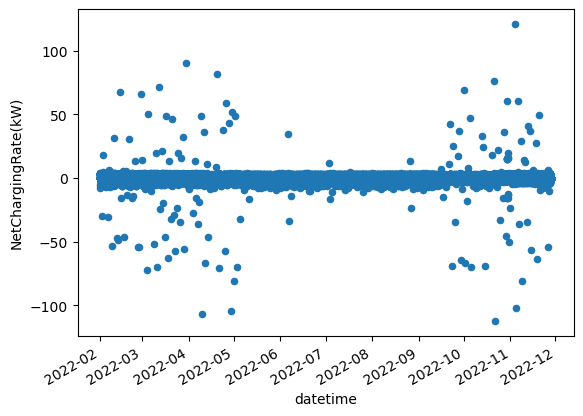

In [17]:
all_battery_data.plot(x='datetime', y='NetChargingRate(kW)', kind='scatter')
# all_battery_data.to_csv(os.path.join("data", "all_battery_data.csv"))
plt.gcf().autofmt_xdate()

# Calculate Carbon consumption for every day in the dataset

Currently, all CI data and battery consumption data has been imported. Now the values need to be calculated on a daily basis, as previously done, to find how much carbon was induced per day with the current batter charge/discharge regime. 

After this, values should be calculated for what the potential induced carbon could be if the battery was optimised to reduce carbon consumption as the highest priority.

In [18]:
all_ci_data.head(2)

,Datetime (UTC),Actual Carbon Intensity (gCO2/kWh),Forecast Carbon Intensity (gCO2/kWh),Index,datetime
7205,2022-01-01T00:00Z,71.0,83,low,2022-01-01 00:00:00
7206,2022-01-01T00:30Z,74.0,74,low,2022-01-01 00:30:00


-744.0071560902758

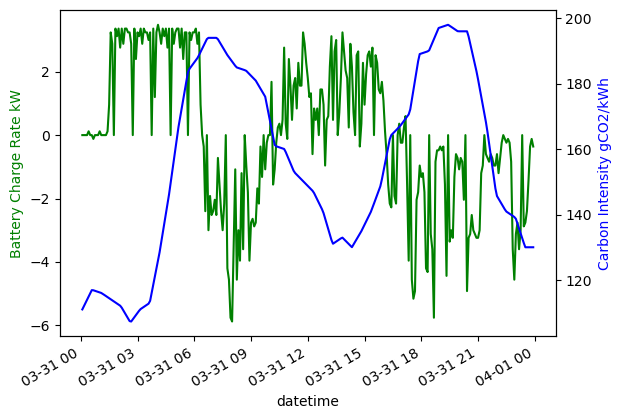

In [19]:
instance_ci_and_battery_data = data_tools.prepare_ci_and_battery_data(day_str="2022-03-31", 
                                                                      battery_data=all_battery_data, 
                                                                      ci_data=all_ci_data)

fig,ax1 = plt.subplots()

ax1.plot(instance_ci_and_battery_data["datetime"], instance_ci_and_battery_data["battery_power_consumption/kW"], color='g')
ax1.set_xlabel("datetime")
ax1.set_ylabel("Battery Charge Rate kW", color='g')

ax2=ax1.twinx()
ax2.plot(instance_ci_and_battery_data['datetime'], instance_ci_and_battery_data['act_carbon_intensity/(gCO2/kWh)'], color='b')
ax2.set_ylabel("Carbon Intensity gCO2/kWh", color='b')
plt.gcf().autofmt_xdate()

carbon_calculation_tools.calculate_carbon_from_day(instance_ci_and_battery_data)


*** Note *** 

The values seem to disagree with the maximum charging rate of the battery at 3kW. The cause of this is the roundoff errors when calculating the net battery charge rate. This is calculated by taking the difference in accumilated charge, named Charging(kWh) in the data, at the time intervals provided, and multiplying by a scaling parameter. 

Apart from this note, the method works.

# Calculate battery co2 contribution for each day in dataset and export as csv

In [20]:
all_days_in_ci_data = list(dict.fromkeys([dtime.strftime("%Y-%m-%d") for dtime in all_ci_data["datetime"]])) # no duplicates
all_days_with_data = [dtime.strftime("%Y-%m-%d") for dtime in all_battery_data["datetime"] if dtime.strftime("%Y-%m-%d") in all_days_in_ci_data]
all_days_with_data = list(dict.fromkeys(all_days_with_data)) # no duplicates

print(f"{len(all_days_with_data)} number of days included in both ci and battery data")

carbon_intensity_each_day = {}

for day in all_days_with_data:
    
    try: 
        instance_ci_and_battery_data = data_tools.prepare_ci_and_battery_data(day_str=day, 
                                                                          battery_data=all_battery_data, 
                                                                          ci_data=all_ci_data)
    except ValueError: # occurs when ci data is not available for that day, even though the day appears in the df
        continue
    
    carbon_for_that_day = carbon_calculation_tools.calculate_carbon_from_day(instance_ci_and_battery_data)
    
    carbon_intensity_each_day[day] = round(carbon_for_that_day, 3)

print(f"{len(carbon_intensity_each_day)} number of days with complete data")

carbon_intensity_each_day

dates = carbon_intensity_each_day.keys()
carbon_values = carbon_intensity_each_day.values()
carbon_daily_data = pd.DataFrame(data=carbon_values, index=dates, columns=["carbon contribution/g"])
carbon_daily_data.to_csv(os.path.join("data", "analysis", "daily_carbon_contribution_from_battery.csv"))

269 number of days included in both ci and battery data
268 number of days with complete data
